#Analiza spłaty należności przez posiadaczy kart kredytowych.

###Wstęp

Posiadacze kart kredytowych są klientami dużego bank komercyjnego w Tajwanie działającego na rynku kredytów w tym m.in. wydającego karty kredytowe dla swoich klientów. Zadanie polega optymalizacji dochodów banku od obecnych klientów, którzy posiadają kartę kredytową. Firma dysponuje bazą 30 000 klientów. Celem projektu jest wykonanie analizy zbioru danych i zbadanie, którzy kliencie (o jakich cechach) mają największą szanse na niespłacenie kredytu w przyszłym miesiącu co pozwoli wyznaczyć wystąpienie niewypłacalności klienta.

Wyniki analizy oprócz samej oceny spłaty przez klientów należności w przyszłym miesiącu na obecnej karcie kredytowej mogą być wykorzystane do oceny wniosku o wydanie nowej karty kredytowej oraz wykorzystane do ogólnej oceny wiarygodności klienta np. przy przyznawaniu kredytu konsumpcyjnego lub przy dostosowaniu ofert innych produktów bankowych. Podczas procesu wydawania karty kredytowej pracownik banku może podjąć decyzje o przyznaniu lub odmowie przyznania karty kredytowej osobie wnioskującej. Za przypadek pozytywny uznajemy zdarzenie niespłacenia zobowiązania przez klienta banku {1}, a brak zdarzenia niespłacenia za zdarzenie negatywne {0}.

###Opis zbioru danych

W projekcie zostały użyte dane pochodzące ze strony https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

Autorem danych jest I-Cheng Yeh z Department of Information Management, Chung Hua University, Taiwan.
Dane dotyczą zaległości w spłatach przez klientów banku na Tajwanie.

Opis zbioru danych:

- Ilość obserwacji: 30000,
- Typy atrybutów: liczby zmiennoprzecinkowe (Real), liczby całkowite (Integer),
- Ilość atrybutów: 24
- Data dodania: 26.01.2016
- Braki w danych: Brak

Opis atrybutów:

- Y: Zmienna objaśniana określająca zdarzenie pozytywne - brak spłaty zobowiązania w kolejnym miesiącu (październiku 2005) (1=Tak, 0=Nie),
- ID: Kolejny numer wiersza
- LIMIT_BAL: Limit przyznanego kredytu w TWD (dolar tajwański) (uwzględnia daną osobę i jej najbliższą rodzinę),
- SEX: Płeć (1 = mężczyzna; 2 = kobieta),
- EDUCATION: Wykształcenie (1 = wyższe pełne (graduate school); 2 = wyższe; 3 = średnie; 4 = inne),
- MARRIAGE: Stan cywilny (1 = zamężna/żonaty; 2 = wolny; 3 = inny),
- AGE: Wiek (w latach),
- PAY_0 - PAY_6: Historia poprzednich spłat od kwietnia 2005 do września 2005, podana w następujący sposób: PAY_0 = stan spłaty we wrześniu 2005; PAY_2 = stan spłaty w sierpniu 2005 ... PAY_6 = stan spłaty w kwietniu 2005 (-1 = płatność w terminie; 1 = opóźnienie o 1 miesiąc; 2 = opóźnienie o 2 miesiące; ... ; 9 = opóźnienie o 9 miesięcy lub więcej). Dodatkowo występują wartości -2 i 0, których interpretacja podana jest jako: -2 i 0 = nie ma żadnego salda płatności.
- BILL_AMT1 - BILL_AMT6: Wartość na wyciągu w TWD (BILL_AMT1 = wyciąg za wrzesień 2005; BILL_AMT2 = wyciąg za sierpień 2005; ... ; BILL_AMT6 = wyciąg za kwiecień 2005),
- PAY_AMT1 - PAY_AMT6: Wartość poprzednich płatności (PAY_AMT1 = suma płatności we wrześniu 2005, PAY_AMT2 = suma płatności w sierpniu 2005; ... ; PAY_AMT6 = suma płatności w kwietniu 2005).

####Import bibliotek

In [0]:
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

In [0]:
%fs
ls /FileStore/tables

path,name,size
dbfs:/FileStore/tables/default_of_credit_card_clients.csv,default_of_credit_card_clients.csv,2897187
dbfs:/FileStore/tables/delays-1.csv,delays-1.csv,256554126
dbfs:/FileStore/tables/delays-2.csv,delays-2.csv,256554126
dbfs:/FileStore/tables/delays.csv,delays.csv,256554126


####Import zbioru danych

In [0]:
d = spark.read.format('com.databricks.spark.csv')\
  .options(inferSchema="true",header='true', delimiter=';')\
  .load('/FileStore/tables/default_of_credit_card_clients.csv')

###Wstępna analiza

In [0]:
d.head(5)

Out[4]: [Row(ID=1, LIMIT_BAL=20000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=24, PAY_0=2, PAY_2=2, PAY_3=-1, PAY_4=-1, PAY_5=-2, PAY_6=-2, BILL_AMT1=3913, BILL_AMT2=3102, BILL_AMT3=689, BILL_AMT4=0, BILL_AMT5=0, BILL_AMT6=0, PAY_AMT1=0, PAY_AMT2=689, PAY_AMT3=0, PAY_AMT4=0, PAY_AMT5=0, PAY_AMT6=0, Y=1),
 Row(ID=2, LIMIT_BAL=120000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682, BILL_AMT2=1725, BILL_AMT3=2682, BILL_AMT4=3272, BILL_AMT5=3455, BILL_AMT6=3261, PAY_AMT1=0, PAY_AMT2=1000, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=0, PAY_AMT6=2000, Y=1),
 Row(ID=3, LIMIT_BAL=90000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=34, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239, BILL_AMT2=14027, BILL_AMT3=13559, BILL_AMT4=14331, BILL_AMT5=14948, BILL_AMT6=15549, PAY_AMT1=1518, PAY_AMT2=1500, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=1000, PAY_AMT6=5000, Y=0),
 Row(ID=4, LIMIT_BAL=50000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=37, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=46990, BILL_AMT2=48233, BILL_AMT3=49291, BILL_AMT4=28314, BILL_AMT5=28959, BILL_AMT6=29547, PAY_AMT1=2000, PAY_AMT2=2019, PAY_AMT3=1200, PAY_AMT4=1100, PAY_AMT5=1069, PAY_AMT6=1000, Y=0),
 Row(ID=5, LIMIT_BAL=50000, SEX=1, EDUCATION=2, MARRIAGE=1, AGE=57, PAY_0=-1, PAY_2=0, PAY_3=-1, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=8617, BILL_AMT2=5670, BILL_AMT3=35835, BILL_AMT4=20940, BILL_AMT5=19146, BILL_AMT6=19131, PAY_AMT1=2000, PAY_AMT2=36681, PAY_AMT3=10000, PAY_AMT4=9000, PAY_AMT5=689, PAY_AMT6=679, Y=0)]

In [0]:
print ('Ilość obserwacji:')
d.count()

Ilość obserwacji:
Out[5]: 30000

In [0]:
print('Typy poszczególnych zmiennych:')
d.printSchema()

Typy poszczególnych zmiennych:
root
-- ID: integer (nullable = true)
-- LIMIT_BAL: integer (nullable = true)
-- SEX: integer (nullable = true)
-- EDUCATION: integer (nullable = true)
-- MARRIAGE: integer (nullable = true)
-- AGE: integer (nullable = true)
-- PAY_0: integer (nullable = true)
-- PAY_2: integer (nullable = true)
-- PAY_3: integer (nullable = true)
-- PAY_4: integer (nullable = true)
-- PAY_5: integer (nullable = true)
-- PAY_6: integer (nullable = true)
-- BILL_AMT1: integer (nullable = true)
-- BILL_AMT2: integer (nullable = true)
-- BILL_AMT3: integer (nullable = true)
-- BILL_AMT4: integer (nullable = true)
-- BILL_AMT5: integer (nullable = true)
-- BILL_AMT6: integer (nullable = true)
-- PAY_AMT1: integer (nullable = true)
-- PAY_AMT2: integer (nullable = true)
-- PAY_AMT3: integer (nullable = true)
-- PAY_AMT4: integer (nullable = true)
-- PAY_AMT5: integer (nullable = true)
-- PAY_AMT6: integer (nullable = true)
-- Y: integer (nullable = true)

In [0]:
print('Ilość braków w danych:')
d.filter(d.ID.isNull() & d.LIMIT_BAL.isNull() & d.SEX.isNull() & d.EDUCATION.isNull() & d.MARRIAGE.isNull() & d.AGE.isNull()\
         & d.PAY_0.isNull() & d.PAY_2.isNull() & d.PAY_3.isNull() & d.PAY_4.isNull() & d.PAY_5.isNull() & d.PAY_6.isNull()\
         & d.BILL_AMT1.isNull() & d.BILL_AMT2.isNull() & d.BILL_AMT3.isNull() & d.BILL_AMT4.isNull() & d.BILL_AMT5.isNull() & d.BILL_AMT6.isNull()\
         & d.PAY_AMT1.isNull() & d.PAY_AMT2.isNull() & d.PAY_AMT3.isNull() & d.PAY_AMT4.isNull() & d.PAY_AMT5.isNull() & d.PAY_AMT6.isNull()\
         & d.Y.isNull())\
         .count()

Ilość braków w danych:
Out[7]: 0

###Zmiana nazw atrybutów

In [0]:
#zmiana nazw atrybutów dla łatwiejszej analizy
d2=d.withColumnRenamed("PAY_0", "PAY_SEP")\
  .withColumnRenamed("PAY_2", "PAY_AUG")\
  .withColumnRenamed("PAY_3", "PAY_JUL")\
  .withColumnRenamed("PAY_4", "PAY_JUN")\
  .withColumnRenamed("PAY_5", "PAY_MAY")\
  .withColumnRenamed("PAY_6", "PAY_APR")\
  .withColumnRenamed("BILL_AMT1", "BILL_AMT_SEP")\
  .withColumnRenamed("BILL_AMT2", "BILL_AMT_AUG")\
  .withColumnRenamed("BILL_AMT3", "BILL_AMT_JUL")\
  .withColumnRenamed("BILL_AMT4", "BILL_AMT_JUN")\
  .withColumnRenamed("BILL_AMT5", "BILL_AMT_MAY")\
  .withColumnRenamed("BILL_AMT6", "BILL_AMT_APR")\
  .withColumnRenamed("PAY_AMT1", "PAY_AMT_SEP")\
  .withColumnRenamed("PAY_AMT2", "PAY_AMT_AUG")\
  .withColumnRenamed("PAY_AMT3", "PAY_AMT_JUL")\
  .withColumnRenamed("PAY_AMT4", "PAY_AMT_JUN")\
  .withColumnRenamed("PAY_AMT5", "PAY_AMT_MAY")\
  .withColumnRenamed("PAY_AMT6", "PAY_AMT_APR")

In [0]:
d2.display()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


###Analiza wskaźników statystycznych

In [0]:
d2.describe("Y","ID","LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE").show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
summary| Y| ID| LIMIT_BAL| SEX| EDUCATION| MARRIAGE| AGE|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
 count| 30000| 30000| 30000| 30000| 30000| 30000| 30000|
 mean| 0.2212| 15000.5|167484.32266666667|1.6037333333333332|1.8531333333333333|1.5518666666666667| 35.4855|
 stddev|0.41506180569093254|8660.398374208891|129747.66156720246|0.4891291960902602|0.7903486597207269|0.5219696006132467|9.217904068090155|
 min| 0| 1| 10000| 1| 0| 0| 21|
 max| 1| 30000| 1000000| 2| 6| 3| 79|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+

In [0]:
d2.describe("PAY_SEP","PAY_AUG","PAY_JUL","PAY_JUN","PAY_MAY","PAY_APR").show()

+-------+------------------+--------------------+------------------+--------------------+------------------+-----------------+
summary| PAY_SEP| PAY_AUG| PAY_JUL| PAY_JUN| PAY_MAY| PAY_APR|
+-------+------------------+--------------------+------------------+--------------------+------------------+-----------------+
 count| 30000| 30000| 30000| 30000| 30000| 30000|
 mean| -0.0167|-0.13376666666666667| -0.1662|-0.22066666666666668| -0.2662| -0.2911|
 stddev|1.1238015279973335| 1.1971859730345495|1.1968675684465686| 1.1691386224023357|1.1331874060027525|1.149987625607897|
 min| -2| -2| -2| -2| -2| -2|
 max| 8| 8| 8| 8| 8| 8|
+-------+------------------+--------------------+------------------+--------------------+------------------+-----------------+

In [0]:
d2.describe("BILL_AMT_SEP","BILL_AMT_AUG","BILL_AMT_JUL","BILL_AMT_JUN","BILL_AMT_MAY","BILL_AMT_APR").show()

+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+
summary| BILL_AMT_SEP| BILL_AMT_AUG| BILL_AMT_JUL| BILL_AMT_JUN| BILL_AMT_MAY| BILL_AMT_APR|
+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+
 count| 30000| 30000| 30000| 30000| 30000| 30000|
 mean| 51223.3309|49179.07516666667| 47013.1548| 43262.94896666666|40311.40096666667| 38871.7604|
 stddev|73635.86057552966|71173.76878252832|69349.38742703677|64332.856133916444|60797.15577026471|59554.1075367459|
 min| -165580| -69777| -157264| -170000| -81334| -339603|
 max| 964511| 983931| 1664089| 891586| 927171| 961664|
+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+

In [0]:
d2.describe("PAY_AMT_SEP","PAY_AMT_AUG","PAY_AMT_JUL","PAY_AMT_JUN","PAY_AMT_MAY","PAY_AMT_APR").show()

+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
summary| PAY_AMT_SEP| PAY_AMT_AUG| PAY_AMT_JUL| PAY_AMT_JUN| PAY_AMT_MAY| PAY_AMT_APR|
+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
 count| 30000| 30000| 30000| 30000| 30000| 30000|
 mean| 5663.5805| 5921.1635| 5225.6815| 4826.076866666666| 4799.387633333334|5215.502566666667|
 stddev|16563.28035402577|23040.870402057186|17606.96146980311|15666.159744032062|15278.305679144742|17777.46577543531|
 min| 0| 0| 0| 0| 0| 0|
 max| 873552| 1684259| 896040| 621000| 426529| 528666|
+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+

####Rozkłady wartości atrybutów i zmiennej celu

In [0]:
d2.groupBy("Y")\
  .count()\
  .sort("Y", ascending=False)\
  .display()

Y,count
1,6636
0,23364


In [0]:
d2.groupBy("SEX")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("SEX", ascending=True)\
  .display()

SEX,Ilość_klientów,Ilość_niewiarygodnych_klientów
1,11888,2873
2,18112,3763


In [0]:
d2.groupBy("EDUCATION")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("EDUCATION", ascending=True)\
  .display()

EDUCATION,Ilość_klientów,Ilość_niewiarygodnych_klientów
0,14,0
1,10585,2036
2,14030,3330
3,4917,1237
4,123,7
5,280,18
6,51,8


In [0]:
d2.groupBy("MARRIAGE")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("MARRIAGE", ascending=True)\
  .display()

MARRIAGE,Ilość_klientów,Ilość_niewiarygodnych_klientów
0,54,5
1,13659,3206
2,15964,3341
3,323,84


In [0]:
d2.groupBy("PAY_SEP")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("PAY_SEP", ascending=True)\
  .display()

PAY_SEP,Ilość_klientów,Ilość_niewiarygodnych_klientów
-2,2759,365
-1,5686,954
0,14737,1888
1,3688,1252
2,2667,1844
3,322,244
4,76,52
5,26,13
6,11,6
7,9,7


In [0]:
d2.groupBy("PAY_AUG")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("PAY_AUG", ascending=True)\
  .display()

PAY_AUG,Ilość_klientów,Ilość_niewiarygodnych_klientów
-2,3782,691
-1,6050,966
0,15730,2503
1,28,5
2,3927,2184
3,326,201
4,99,50
5,25,15
6,12,9
7,20,12


In [0]:
d2.groupBy("PAY_JUL")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("PAY_JUL", ascending=True)\
  .display()

PAY_JUL,Ilość_klientów,Ilość_niewiarygodnych_klientów
-2,4085,757
-1,5938,926
0,15764,2751
1,4,1
2,3819,1969
3,240,138
4,76,44
5,21,12
6,23,14
7,27,22


In [0]:
d2.groupBy("PAY_JUN")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("PAY_JUN", ascending=True)\
  .display()

PAY_JUN,Ilość_klientów,Ilość_niewiarygodnych_klientów
-2,4348,837
-1,5687,904
0,16455,3016
1,2,1
2,3159,1653
3,180,110
4,69,46
5,35,18
6,5,2
7,58,48


In [0]:
d2.groupBy("PAY_MAY")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("PAY_MAY", ascending=True)\
  .display()

PAY_MAY,Ilość_klientów,Ilość_niewiarygodnych_klientów
-2,4546,895
-1,5539,897
0,16947,3195
2,2626,1423
3,178,113
4,84,51
5,17,10
6,4,3
7,58,48
8,1,1


In [0]:
d2.groupBy("PAY_APR")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("PAY_APR", ascending=True)\
  .display()

PAY_APR,Ilość_klientów,Ilość_niewiarygodnych_klientów
-2,4895,981
-1,5740,975
0,16286,3069
2,2766,1401
3,184,118
4,49,31
5,13,7
6,19,14
7,46,38
8,2,2


In [0]:
d2.groupBy("AGE")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("AGE", ascending=True)\
  .display()

AGE,Ilość_klientów,Ilość_niewiarygodnych_klientów
21,67,14
22,560,169
23,931,247
24,1127,300
25,1186,302
26,1256,253
27,1477,313
28,1409,286
29,1605,313
30,1395,274


In [0]:
d2.groupBy("LIMIT_BAL")\
  .agg(\
       f.count("Y"),\
       f.sum("Y"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("sum(Y)", "Ilość_niewiarygodnych_klientów")\
  .sort("LIMIT_BAL", ascending=True)\
  .display()

LIMIT_BAL,Ilość_klientów,Ilość_niewiarygodnych_klientów
10000,493,197
16000,2,0
20000,1976,698
30000,1610,568
40000,230,92
50000,3365,885
60000,825,233
70000,731,210
80000,1567,363
90000,651,166


####Atrybuty a zmienna celu

In [0]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=d2.columns, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(d2).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)
#matrix.collect()[0]["pearson({})".format(vector_col)].values

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

df_corr = spark.createDataFrame(corrmatrix,d2.columns)
df_corr.display()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,Y
1.0,0.02617915774620167,0.018497494176206487,0.03917673481156471,-0.02907942531877752,0.01867773449026759,-0.030574932272971814,-0.01121486826234514,-0.018493553757696724,-0.002734889781959251,-0.022199231870023994,-0.02027013406721427,0.019388673917611655,0.017981897457701266,0.024354050018842197,0.04035060294250619,0.016705303156352165,0.016729618316254097,0.009742443464325134,0.008406120336440032,0.03915053548888703,0.007793129725698553,6.521877787618003E-4,0.002999780722525998,-0.013951954838985101
0.02617915774620167,1.0,0.02475523511163555,-0.2191606982291959,-0.10813941027805507,0.14471279755733535,-0.2712143321346567,-0.2963821009965286,-0.28612295390311204,-0.2674600096394004,-0.24941139482420557,-0.23519539948551665,0.28542986496500206,0.2783143639977738,0.2832357835816964,0.29398762371600234,0.2955623376582494,0.2903889506479486,0.19523591523218448,0.17840795368370896,0.21016674772340757,0.20324241022461373,0.21720243239551598,0.21959536860441445,-0.15351987639346343
0.018497494176206487,0.02475523511163555,1.0,0.014231936162200488,-0.03138884007084519,-0.09087364652736216,-0.057642878866969574,-0.07077100316681816,-0.06609605640039136,-0.06017323836618153,-0.05506388503522231,-0.04400778818764644,-0.03364186958913818,-0.031183472229657703,-0.024563311681397113,-0.02187967907347758,-0.01700518018732044,-0.01673312634815424,-2.4245456294126144E-4,-0.0013909096590861713,-0.008596624911740763,-0.002228971507005173,-0.001667161800472977,-0.0027660222828914476,-0.03996057770542551
0.03917673481156471,-0.2191606982291959,0.014231936162200488,1.0,-0.1434643404115025,0.1750606614880606,0.1053639979353217,0.12156555247068518,0.1140249028570981,0.10879345615279203,0.09752016063020952,0.0823159863774773,0.023581180737112153,0.018748770808320114,0.013002400711997125,-4.5134530874863915E-4,-0.007566503046841201,-0.009098954697454408,-0.03745618391311018,-0.030038186562840748,-0.03994314086709915,-0.038218166111340386,-0.040358454928189014,-0.03719990308916863,0.028006077656248764
-0.02907942531877752,-0.10813941027805507,-0.03138884007084519,-0.1434643404115025,1.0,-0.4141699184882205,0.019917190483428878,0.02419906728119957,0.032687673337238085,0.03312154891406013,0.035629170366567695,0.0343447659974502,-0.02347180191013448,-0.021601779859033384,-0.024909451022505007,-0.02334384691538172,-0.025393397991281687,-0.02120682480008344,-0.005978999780834794,-0.008092702837780973,-0.0035413519467558403,-0.012659278892723046,-0.0012047569155654143,-0.0066409419256555306,-0.024339215683412744
0.01867773449026759,0.14471279755733535,-0.09087364652736216,0.1750606614880606,-0.4141699184882205,1.0,-0.03944737618411941,-0.0501477762068607,-0.053048437258154606,-0.04972167399538046,-0.05382597641308427,-0.048773426428328076,0.05623853326056597,0.0542830743503408,0.053709705178658834,0.05135309324331931,0.0493450481126114,0.04761267799051194,0.026146679056987643,0.02178489339261584,0.02924735304500812,0.021379005615590526,0.022849973558557574,0.01947815296987061,0.013889834301962101
-0.030574932272971814,-0.2712143321346567,-0.057642878866969574,0.1053639979353217,0.019917190483428878,-0.03944737618411941,1.0,0.6721643825485115,0.5742450926205569,0.5388406268711886,0.5094260636655171,0.47455308606419927,0.18706843147381264,0.18985910889354435,0.17978528216681358,0.1791247706258811,0.18063462540120695,0.17698029564143672,-0.07926871118542084,-0.07010052119394597,-0.07056083767035247,-0.06400488888773287,-0.05818988594977962,-0.058673214376076255,0.324793728478616
-0.01121486826234514,-0.2963821009965286,-0.07077100316681816,0.12156555247068518,0.02419906728119957,-0.0501477762068607,0.6721643825485115,1.0,0.7665516829340647,0.6620671310240177,0.6227802453771065,0.5755008617794777,0.2348865266036141,0.2352569

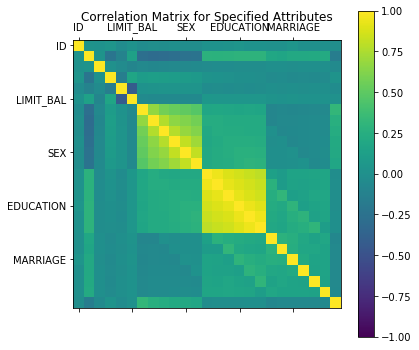

In [0]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no,figsize=(6,6))
    plt.figure(figsize=(200,100))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
plot_corr_matrix(corrmatrix, d2.columns, 263)

In [0]:
d2.corr('AGE', 'Y') 

Out[27]: 0.01388983430196289

In [0]:
d2.groupBy("Y")\
  .agg(\
       f.count("Y"),\
       f.round(f.mean("AGE"),2).alias("Wiek"),\
       f.round(f.mean("LIMIT_BAL"),2).alias("Średni_limit_kredytowy"),\
       f.round(f.mean("PAY_SEP"),2).alias("Średnia_spłata_wrz"),\
       f.round(f.mean("PAY_AUG"),2).alias("Średnia_spłata_sie"),\
       f.round(f.mean("PAY_JUL"),2).alias("Średnia_spłata_lip"),\
       f.round(f.mean("PAY_JUN"),2).alias("Średnia_spłata_cze"),\
       f.round(f.mean("PAY_MAY"),2).alias("Średnia_spłata_maj"),\
       f.round(f.mean("PAY_APR"),2).alias("Średnia_spłata_kwi"),\
       f.round(f.mean("BILL_AMT_SEP"),2).alias("Średni_wyciąg_wrz"),\
       f.round(f.mean("BILL_AMT_AUG"),2).alias("Średni_wyciąg_sie"),\
       f.round(f.mean("BILL_AMT_JUL"),2).alias("Średni_wyciąg_lip"),\
       f.round(f.mean("BILL_AMT_JUN"),2).alias("Średni_wyciąg_cze"),\
       f.round(f.mean("BILL_AMT_MAY"),2).alias("Średni_wyciąg_maj"),\
       f.round(f.mean("BILL_AMT_APR"),2).alias("Średni_wyciąg_kwi"),\
       f.round(f.mean("PAY_AMT_SEP"),2).alias("Średnia_płatność_wrz"),\
       f.round(f.mean("PAY_AMT_AUG"),2).alias("Średnia_płatność_sie"),\
       f.round(f.mean("PAY_AMT_JUL"),2).alias("Średnia_płatność_lip"),\
       f.round(f.mean("PAY_AMT_JUN"),2).alias("Średnia_płatność_cze"),\
       f.round(f.mean("PAY_AMT_MAY"),2).alias("Średnia_płatność_maj"),\
       f.round(f.mean("PAY_AMT_APR"),2).alias("Średnia_płatność_kwi"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .sort("Ilość_klientów", ascending=False)\
  .display()

Y,Ilość_klientów,Wiek,Średni_limit_kredytowy,Średnia_spłata_wrz,Średnia_spłata_sie,Średnia_spłata_lip,Średnia_spłata_cze,Średnia_spłata_maj,Średnia_spłata_kwi,Średni_wyciąg_wrz,Średni_wyciąg_sie,Średni_wyciąg_lip,Średni_wyciąg_cze,Średni_wyciąg_maj,Średni_wyciąg_kwi,Średnia_płatność_wrz,Średnia_płatność_sie,Średnia_płatność_lip,Średnia_płatność_cze,Średnia_płatność_maj,Średnia_płatność_kwi
0,23364,35.42,178099.73,-0.21,-0.3,-0.32,-0.36,-0.39,-0.41,51994.23,49717.44,47533.37,43611.17,40530.45,39042.27,6307.34,6640.47,5753.5,5300.53,5248.22,5719.37
1,6636,35.73,130109.66,0.67,0.46,0.36,0.25,0.17,0.11,48509.16,47283.62,45181.6,42036.95,39540.19,38271.44,3397.04,3388.65,3367.35,3155.63,3219.14,3441.48


In [0]:
d2.filter ("AGE<60")\
  .groupBy("Y")\
  .agg(\
       f.count("Y"),\
       f.round(f.mean("AGE"),2).alias("Wiek"),\
       f.round(f.mean("LIMIT_BAL"),2).alias("Średni_limit_kredytowy"),\
       f.round(f.mean("PAY_SEP"),2).alias("Średnia_spłata_wrz"),\
       f.round(f.mean("PAY_AUG"),2).alias("Średnia_spłata_sie"),\
       f.round(f.mean("PAY_JUL"),2).alias("Średnia_spłata_lip"),\
       f.round(f.mean("PAY_JUN"),2).alias("Średnia_spłata_cze"),\
       f.round(f.mean("PAY_MAY"),2).alias("Średnia_spłata_maj"),\
       f.round(f.mean("PAY_APR"),2).alias("Średnia_spłata_kwi"),\
       f.round(f.mean("BILL_AMT_SEP"),2).alias("Średni_wyciąg_wrz"),\
       f.round(f.mean("BILL_AMT_AUG"),2).alias("Średni_wyciąg_sie"),\
       f.round(f.mean("BILL_AMT_JUL"),2).alias("Średni_wyciąg_lip"),\
       f.round(f.mean("BILL_AMT_JUN"),2).alias("Średni_wyciąg_cze"),\
       f.round(f.mean("BILL_AMT_MAY"),2).alias("Średni_wyciąg_maj"),\
       f.round(f.mean("BILL_AMT_APR"),2).alias("Średni_wyciąg_kwi"),\
       f.round(f.mean("PAY_AMT_SEP"),2).alias("Średnia_płatność_wrz"),\
       f.round(f.mean("PAY_AMT_AUG"),2).alias("Średnia_płatność_sie"),\
       f.round(f.mean("PAY_AMT_JUL"),2).alias("Średnia_płatność_lip"),\
       f.round(f.mean("PAY_AMT_JUN"),2).alias("Średnia_płatność_cze"),\
       f.round(f.mean("PAY_AMT_MAY"),2).alias("Średnia_płatność_maj"),\
       f.round(f.mean("PAY_AMT_APR"),2).alias("Średnia_płatność_kwi"))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .sort("Ilość_klientów", ascending=False)\
  .display()

Y,Ilość_klientów,Wiek,Średni_limit_kredytowy,Średnia_spłata_wrz,Średnia_spłata_sie,Średnia_spłata_lip,Średnia_spłata_cze,Średnia_spłata_maj,Średnia_spłata_kwi,Średni_wyciąg_wrz,Średni_wyciąg_sie,Średni_wyciąg_lip,Średni_wyciąg_cze,Średni_wyciąg_maj,Średni_wyciąg_kwi,Średnia_płatność_wrz,Średnia_płatność_sie,Średnia_płatność_lip,Średnia_płatność_cze,Średnia_płatność_maj,Średnia_płatność_kwi
0,23121,35.12,177969.9,-0.21,-0.3,-0.32,-0.36,-0.39,-0.41,51781.94,49501.33,47330.34,43401.53,40334.06,38833.24,6309.12,6653.61,5733.07,5307.48,5231.55,5723.42
1,6540,35.32,129358.97,0.67,0.46,0.37,0.26,0.17,0.12,48499.17,47317.25,45186.86,42053.5,39535.41,38295.81,3389.54,3382.33,3383.82,3170.02,3234.72,3429.47


In [0]:
d2.select("Y","AGE", "LIMIT_BAL").display()

Y,AGE,LIMIT_BAL
1,24,20000
1,26,120000
0,34,90000
0,37,50000
0,57,50000
0,37,50000
0,29,500000
0,23,100000
0,28,140000
0,35,20000


In [0]:
d2.select("Y","AGE", "BILL_AMT_SEP").display()

Y,AGE,BILL_AMT_SEP
1,24,3913
1,26,2682
0,34,29239
0,37,46990
0,57,8617
0,37,64400
0,29,367965
0,23,11876
0,28,11285
0,35,0


###Dodatkowe analizy

In [0]:
d2.groupBy("AGE")\
  .mean()\
  .sort("AGE", ascending=True)\
  .display()

AGE,avg(ID),avg(LIMIT_BAL),avg(SEX),avg(EDUCATION),avg(MARRIAGE),avg(AGE),avg(PAY_SEP),avg(PAY_AUG),avg(PAY_JUL),avg(PAY_JUN),avg(PAY_MAY),avg(PAY_APR),avg(BILL_AMT_SEP),avg(BILL_AMT_AUG),avg(BILL_AMT_JUL),avg(BILL_AMT_JUN),avg(BILL_AMT_MAY),avg(BILL_AMT_APR),avg(PAY_AMT_SEP),avg(PAY_AMT_AUG),avg(PAY_AMT_JUL),avg(PAY_AMT_JUN),avg(PAY_AMT_MAY),avg(PAY_AMT_APR),avg(Y)
21,13814.10447761194,23283.582089552237,1.6865671641791045,2.1044776119402986,1.8805970149253732,21.0,0.19402985074626866,0.08955223880597014,0.19402985074626866,0.014925373134328358,-0.29850746268656714,-0.5522388059701493,16961.567164179105,16066.34328358209,14515.701492537313,12768.373134328358,11055.074626865671,7790.910447761194,2085.776119402985,1749.7164179104477,1179.865671641791,1381.865671641791,827.6567164179105,568.2089552238806,0.208955223880597
22,13799.010714285714,37928.57142857143,1.7517857142857143,1.9696428571428573,1.917857142857143,22.0,0.40535714285714286,0.4017857142857143,0.3464285714285714,0.15714285714285714,0.07857142857142857,0.04642857142857143,24176.14642857143,23766.019642857143,22515.45,19718.173214285714,16932.230357142857,15539.044642857143,2369.5375,2408.1875,1845.0535714285713,1743.6660714285715,1661.5214285714285,1542.9303571428572,0.30178571428571427
23,14262.79269602578,59752.95381310419,1.7207303974221269,1.8882921589688506,1.9054779806659505,23.0,0.2502685284640172,0.1836734693877551,0.1310418904403867,0.07626208378088077,0.04403866809881848,0.024704618689581095,29910.55209452202,28782.4425349087,26876.41245972073,23830.878625134264,22221.128893662728,21363.386680988184,3239.6509129967776,3167.9924812030076,2833.6186895810956,2633.43716433942,2278.2738990332973,2668.0214822771213,0.2653061224489796
24,14150.837622005323,75661.04702750666,1.6850044365572316,1.8420585625554569,1.8793256433007985,24.0,0.2236024844720497,0.14729370008873113,0.11091393078970718,0.05235137533274179,0.023957409050576754,-0.011535048802129548,33747.83318544809,32483.51286601597,31003.772848269742,27955.181898846495,26043.818101153505,25660.377107364686,3437.509316770186,3456.996450754215,2667.676131322094,2734.072759538598,2987.842945874002,2745.2413487133986,0.26619343389529726
25,14541.063237774031,102731.8718381113,1.6711635750421585,1.7799325463743676,1.8709949409780775,25.0,0.1551433389544688,0.06913996627318718,0.08768971332209106,-0.006745362563237774,-0.05733558178752108,-0.1205733558178752,41777.45699831366,40695.34148397976,38327.6323777403,34916.93591905565,31979.716694772345,30657.220067453625,4711.83389544688,3721.0,3363.674536256324,3640.5387858347385,2949.6989881956156,3636.1365935919057,0.25463743676222594
26,14593.886942675159,128813.69426751592,1.6305732484076434,1.7738853503184713,1.85828025477707,26.0,0.12022292993630573,0.03821656050955414,-0.021496815286624203,-0.07563694267515923,-0.12340764331210191,-0.14888535031847133,47991.857484076434,46151.18312101911,43776.28582802548,39513.84394904459,35831.10350318471,34551.27866242038,4783.46576433121,4635.628184713376,3940.2165605095543,3638.6146496815286,4086.8463375796177,4628.853503184713,0.2014331210191083
27,14975.387271496276,147941.77386594447,1.6418415707515233,1.6899119837508463,1.8348002708192281,27.0,0.04536222071767095,-0.0981719702098849,-0.14624238320920785,-0.18754231550440081,-0.21123899796885579,-0.23696682464454977,48704.807718348005,47436.18280297901,46371.01895734597,43062.86255924171,40918.643872714965,39488.1144211239,5230.849695328368,5302.418415707515,4649.62220717671,4551.387948544347,4556.484766418415,4526.699390656737,0.21191604603926878
28,15146.515968772179,170943.93186657203,1.6408800567778565,1.6643009226401704,1.7984386089425124,28.0,-0.0028388928317956,-0.10432931156848829,-0.13058907026259758,-0.18381831085876507,-0.25833924769339955,-0.2789212207239177,55046.134847409514,52809.04826117814,50035.152590489706,46800.46699787083,43529.201561391055,42447.360539389636,6160.422285308729,5605.646557842441,5783.974449964514,4625.3946061036195,5137.292405961

In [0]:
d2.groupBy("EDUCATION")\
  .agg(\
       f.count("Y"),\
       f.round(f.mean("LIMIT_BAL"),2))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("round(avg(LIMIT_BAL), 2)", "Średni_limit kredytowy")\
  .sort("EDUCATION", ascending=True)\
  .display()

EDUCATION,Ilość klientów,Średni limit kredytowy
0,14,217142.86
1,10585,212956.07
2,14030,147062.44
3,4917,126550.27
4,123,220894.31
5,280,168164.29
6,51,148235.29


In [0]:
d2.groupBy("MARRIAGE")\
  .agg(\
       f.count("Y"),\
       f.round(f.mean("LIMIT_BAL"),2))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("round(avg(LIMIT_BAL), 2)", "Średni_limit_kredytowy")\
  .sort("MARRIAGE", ascending=True)\
  .display()

MARRIAGE,Ilość_klientów,Średni_limit_kredytowy
0,54,132962.96
1,13659,182200.89
2,15964,156413.66
3,323,98080.5


In [0]:
d2.groupBy("SEX")\
  .agg(\
       f.count("Y"),\
       f.round(f.mean("LIMIT_BAL"),2))\
  .withColumnRenamed("count(Y)", "Ilość_klientów")\
  .withColumnRenamed("round(avg(LIMIT_BAL), 2)", "Średni_limit_kredytowy")\
  .sort("SEX", ascending=True)\
  .display()

SEX,Ilość klientów,Średni limit kredytowy
1,11888,163519.83
2,18112,170086.46


###Podsumowanie 

Z ogólnego porównania atrybutów wynika, że dla limitu kredytowego odchylenie standardowe jest bardzo duże równe 129748 przy średniej równej 167484. Średni wiek wynosi 35.5 roku przy odchy. standardowym równym 9.2, ale występują także osoby w wieku emerytalnym. Spłaty w większości są w terminie. Średnia wartość wyciągu w kolejnych miesiącach wzrasta i odchy. standardowe jest znaczne np. dla września wynosi 73636 przy średniej równej 51223 (związane jest to z wielkością limitów kredytowych). Podobnie średnia wartość poprzednich płatności z czasem wzrasta, a odchy. standardowe jest bardzo duże np. dla września wynosi 16563 przy średniej 5664.

Ilość klientów, którzy nie spłacą zobowiązania w przyszłym miesiącu stanowi ok. 22% wszytkich klientów. Zbiór można uznać za niezbalansowany.
W większości klientami są kobiety i stanowią ok. 60%, osoby z wykształceniem wyższym i wyższym pełnym (łącznie ok. 82% klientów) oraz osoby ze stanem cywilnym kawaler/panna (ok. 53%) ale również dużą liczbę stanowią klienci w związku (ok. 46%).
Większość zadłużenia jest spłacana w terminie (wartość -1). Jednak występują przypadki w których spłata przeciąga się do kilku miesięcy oraz występują dużo przypadków braku salda płatności (wartości -2, 0).

Na podstawie zestawienia występowania klientów wiarygodnych/niewiarygodnych dla poszczególnych kategorii atrybutów oraz wspomagając się wykresami proporcji można stwierdzić, że zależność pomiędzy atrybutami a zmienną objaśnianą jest największa dla atrybutów dotyczących terminowej spłaty kredytu. Szczególnie jest to wdoczne dla ostatnich miesięcy (sierpień, wrzesień). Dla pozostałych atrybutów zależność nie jest duża. Największe zróżnicowanie proporcji występuje dla wyksztalcenia (np. dla średniego i wyższego wykształcenia jest duży udział zdarzeń pozytywnych w stosunku do łącznej ilości). Dla płci udział zdarzeń pozytywnych dla mężczyzn jest nieznacznie większy niż dla kobiet. Dla nieznanego stanu cywilnego jest mniej zdarzeń pozytywnych niż dla pozostałych wartości tego atrybutu.

Wykorzytując wyznaczone wartości współczynnika korelacji, można stwierdzić, że atrybuty z grupy stan spłaty są najbardziej skorelowane ze zmienną objaśnianą y. Korelacja wzrasta ze zbliżaniem się do października. Limit kredytu i atrybuty z grupy płatności są w niewielkim stopniu skorelowane ze zmienną objaśnianą y. Wiek i atrybuty z grupy wyciąg są tylko nieznacznie skorelowane ze zmienną objaśnianą y. Oczywiste jest wyciąg jest mocno skorelowany z płatnością, a w szczególności wyciąg w danym miesiącu i płatność w kolejnym miesiącu. Wiek praktycznie nie ma korelacji z żadnym z atrybutów (niewielka z limit kredytu). Zależność pomiędzy atrybutami dotyczącymi wykształcenia, płci i  stanu cywilnego jest stosunkowo mała.

Warto zauważyć, że ogólnie średnia limitu kredytowy, a co za tym idzie średnia wartości wyciągu i płatności w poszczególnych miesiącach jest mniejsza dla klientów oznaczonych jako niewiarygodni {1} w porównaniu do wiarygodnych {0}. To może oznaczać, że klienci niewiarygodni są raczej w grupie osób o mniejszym przyznanym limicie kredytu. Ponadto średnia wartość opóźnienia spłaty zobowiązania dla klientów niewiarygodnych jest dodatnia, a dla wiarygodnych ujemna, co jest w miarę logiczne - kliencie niespłacający zobowiązania w kolejnych miesiącach wkońcu stają się niewiarygodni. Średni wiek klientów jest podobny dla klientów spłacających i niespłacających zobowiązania. 

Dodatkow zgodnie z przedstawionym wykresem widać wzrost limitu kredytowego w zależności od wieku do ok. 30 lat i powolny spadek aż do wieku 60 lat. W tym okresie dla klientów niewiarygodnych wartość limitu kredytowego zachowuje się podobnie jak dla klientów wiarygodnych. Po przekroczenie 60 roku większość ludzi przechodzi na emeryturę i zakres przyznanego limitu kredytowego bardziej się wacha i jest mniej stabilny. Po przekroczeniu 70 roku życia jest mało klientów i wyniki są bardziej losowe.

Na podstawie powyższych danych i wniosków można stwierdzić, że największe znaczenie przy określaniu niewypłacalności klientów w następnym miesiącu ma stan spłaty we wcześniejszych miesiącach, a szczególnie w miesiącach bezpośrednio poprzedzajacych badany mieciąc. Im większe opóźnienie w spłacie tym więcej klientów niewypłacalnych. Znaczenie mają również atrybuty określajace limit kredytowy i powiązany z nim wartości na wyciągu i poprzednich spłat. Okazało się, że klienci niewypłacalni mieli przyznany średnio mniejszy limit kredytowy niż klienci wypłacalni. Dodatkowo klienci o wyższym i średnim wykształceniu stosunkowo częściej nie spłacali zobowiązania niż pozostali.